In [10]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

In [37]:
# the image seemed to be a little off, performing appropriate transformations to correct it.

# Define a custom transformation function
# class RotateAndFlip:
#     def __init__(self, rotation_angle):
#         self.rotation_angle = rotation_angle

#     def __call__(self, image):
#         # Rotate the image
#         image = v2.functional.rotate(image, angle=self.rotation_angle, expand=True)
#         # Flip the image horizontally
#         image = v2.functional.hflip(image)
#         return image


def RotateAndFlip(image):
  image = v2.functional.rotate(image, angle=-90, expand=True)
  image = v2.functional.horizontal_flip(image)
  return image


# Create the transformation pipeline object
transform = v2.Compose([
    transforms.ToTensor(),
    RotateAndFlip  # Apply 90-degree rotation and horizontal flip
])


# or we can use lambda function

transform = v2.Compose([
    transforms.ToTensor(),
    lambda image: v2.functional.rotate(image,angle=-90,expand=True),
    lambda image: v2.functional.horizontal_flip(image)
])

In [40]:
train_data = datasets.EMNIST(root="data",
                             split="letters",
                             train=True,
                             download=True,
                             transform=transform,
                             target_transform=None
                             )

test_data = datasets.EMNIST(root="data",
                            split="letters",
                            train=False,
                            download=True,
                            transform=transform,
                            target_transform=None)

In [21]:
class_names = train_data.classes
print(class_names)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


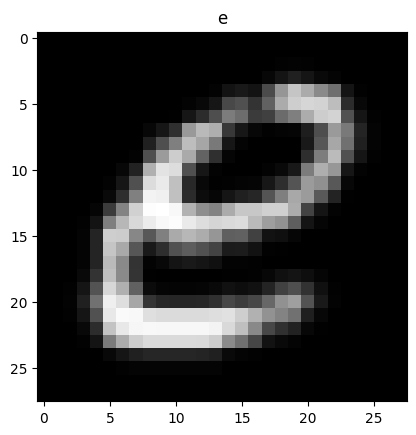

In [42]:
rand_idx = torch.randint(0,len(train_data),size=[1]).item()
img, label = train_data[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.show()

In [ ]:
class_idx = train_data.class_to_idx

## visualizing the data

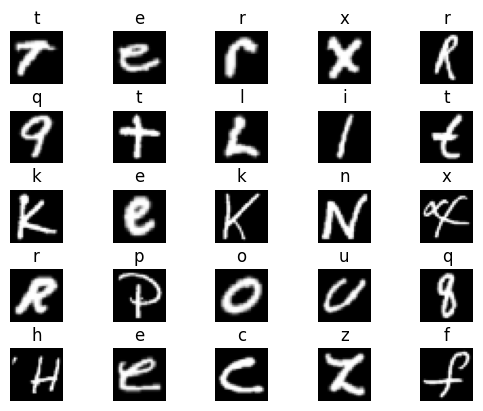

In [ ]:
for i in range(25):
  image, label = train_data[np.random.randint(0,len(train_data))]
  plt.subplot(5,5,i+1)
  plt.imshow(image.squeeze(),cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

plt.subplots_adjust(hspace=0.5)  # Adjust hspace as needed, e.g., 0.5
plt.show()

In [ ]:
# making data batches

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

## Creating the model

In [ ]:
# writing device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print (device)

cuda


In [ ]:
class CharacterClassification(nn.Module):
    def __init__(self,input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )


    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

model = CharacterClassification(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)



In [ ]:
# defining loss and optimizer function

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),lr=0.1)


In [ ]:
# importing helper function
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  req = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(req.content)

from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download


In [ ]:
# training the model

from tqdm.auto import tqdm
epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n ..........")
  train_loss = 0
  train_accuracy = 0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    # train the model
    y_logits = model(X)

    # forward pass
    loss = loss_fn(y_logits, y)

    # calculate loss and accuracy
    accuracy = accuracy_fn(y_true=y, y_pred=y_logits.argmax(dim=1))
    train_accuracy+= accuracy
    train_loss+= loss.item()

    # optimizer
    optimizer.zero_grad()
    # backward propagation
    loss.backward()
    # gradient descent
    optimizer.step()

  print(f"Train loss: {train_loss/len(train_dataloader)}  Train accuracy: {train_accuracy/len(train_dataloader)}")

  test_loss = 0
  test_accuracy = 0
  model.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:
      X, y = X.to(device), y.to(device)
      y_logits = model(X)
      accuracy = accuracy_fn(y_true=y, y_pred=y_logits.argmax(dim=1))
      test_accuracy+= accuracy
      loss = loss_fn(y_logits, y)
      test_loss+= loss.item()

    print(f"Test loss: {test_loss/len(test_dataloader)}  Test accuracy: {test_accuracy/len(test_dataloader)}")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 
 ..........
Train loss: 0.24584224724425718  Train accuracy: 91.9511217948718
Test loss: 0.2723867845076781  Test accuracy: 91.57692307692308
Epoch: 1 
 ..........
Train loss: 0.23834615575961576  Train accuracy: 92.1650641025641
Test loss: 0.264910197693568  Test accuracy: 91.96153846153847
Epoch: 2 
 ..........
Train loss: 0.23261034802366526  Train accuracy: 92.3261217948718
Test loss: 0.2689152939657036  Test accuracy: 91.69711538461539
Epoch: 3 
 ..........
Train loss: 0.22670100613091237  Train accuracy: 92.4775641025641
Test loss: 0.2748051167884842  Test accuracy: 91.32211538461539
Epoch: 4 
 ..........
Train loss: 0.2226319725601337  Train accuracy: 92.64102564102564
Test loss: 0.27281164119449947  Test accuracy: 91.32211538461539


## evaluating model and the test data

In [ ]:
def eval_model(model:nn.Module,
               data_loader:torch.utils.data,
               accuracy_fn,
               loss_fn:nn.Module):
  model.eval()
  loss = 0
  acc = 0
  y_preds=[]

  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_logits = model(X)
      loss+= loss_fn(y_logits, y).item()
      acc+= accuracy_fn(y_true=y, y_pred=y_logits.argmax(dim=1))
      y_preds.append(y_logits.argmax(dim=1).cpu())

  return {"model_name":model.__class__.__name__,
          "model_loss":loss/len(data_loader),
          "model_acc":acc/len(data_loader)
          }, y_preds



In [ ]:
model_evaluation,y_preds = eval_model(model=model,
                            data_loader=test_dataloader,
                            accuracy_fn=accuracy_fn,
                            loss_fn=loss_fn)
model_evaluation

  0%|          | 0/325 [00:00<?, ?it/s]

{'model_name': 'CharacterClassification',
 'model_loss': 0.27281164119449947,
 'model_acc': 91.32211538461539}

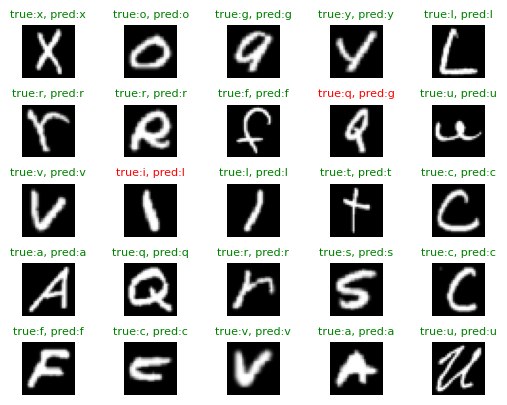

In [ ]:
# visualizing the evaluated model

for i in range(25):
  image, label = test_data[np.random.randint(0,len(test_data))]

  # prediction
  y_logits = model(image.unsqueeze(dim=0).to(device))
  y_pred = class_names[y_logits.argmax(dim=1).item()]
  label = class_names[label]

  # plotting
  color = "green" if y_pred == label else "red"

  plt.subplot(5,5,i+1)
  plt.imshow(image.squeeze(),cmap="gray")
  plt.title(f"true:{label}, pred:{y_pred}", fontsize=8, color=color)
  plt.axis(False)

plt.subplots_adjust(hspace=0.5)  # Adjust hspace as needed, e.g., 0.5
plt.show()

In [ ]:
try:
    import torchmetrics
    print("torchmetrics is already installed.")
except ImportError:
    import pip
    pip.main(['install', 'torchmetrics'])
    print("torchmetrics has been installed.")


torchmetrics is already installed.


In [ ]:
y_preds = torch.cat(y_preds)
y_truth = test_data.targets


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


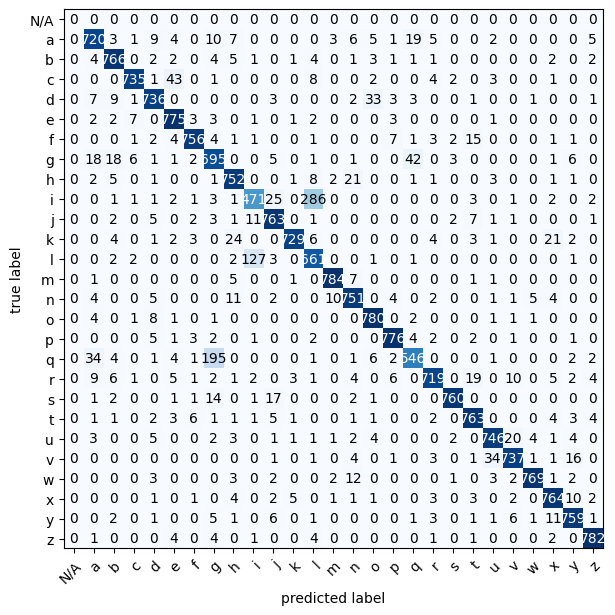

In [ ]:
## creating confusion matrix to see the model's accuracy, it's TPR, TNR, FPR, FNR

from torchmetrics.classification import MulticlassConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
cm = MulticlassConfusionMatrix(num_classes=len(class_names))
cm_tensor = cm(preds=y_preds, target=y_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=cm_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)
plt.show()